In [1]:
import numpy as np
import pandas as pd
import os

from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn as nn
from torch import optim as optim
from torch import functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
here = os.getcwd()
file_paths = {
    "init": here + "\\skeleton2Outputs\\c_init.csv",
    "step_0": here + "\\skeleton2Outputs\\c_step_0.csv",
    "step_100": here + "\\skeleton2Outputs\\c_step_100.csv",
    "step_200": here + "\\skeleton2Outputs\\c_step_200.csv",
    "step_300": here + "\\skeleton2Outputs\\c_step_300.csv",
    "step_400": here + "\\skeleton2Outputs\\c_step_400.csv",
    "step_500": here + "\\skeleton2Outputs\\c_step_500.csv",
}

# Load the data into pandas DataFrames
data_frames = {key: pd.read_csv(file_path, header=None) for key, file_path in file_paths.items()}

# Display the initial file to understand its structure
data_frames['init'].head()

,0,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,244
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Get the grid size from the shape of the data
grid_size_x, grid_size_y = data_frames['init'].shape

# Create the grid coordinates for each (x, y) point
x = np.arange(grid_size_x)
y = np.arange(grid_size_y)
X, Y = np.meshgrid(x, y)

# Initialize an empty list to store the data in the form (x, y, t, M)
data_list = []

# Loop through the dataframes to stack them with time information
time_steps = [0, 100, 200, 300, 400, 500]
for t in time_steps:
    # Get the data for the current time step
    M_t = data_frames[f'step_{t}'].values
    
    # Stack the (x, y), t, and M(x, y, t) for each grid point
    for i in range(grid_size_x):
        for j in range(grid_size_y):
            data_list.append([X[i, j], Y[i, j], t, M_t[i, j]])

# Convert the data list to a NumPy array for easier processing
data_array = np.array(data_list)

# Convert to a pandas DataFrame for clarity
data_df = pd.DataFrame(data_array, columns=['x', 'y', 't', 'M'])

#import ace_tools as tools 

#tools.display_dataframe_to_user(name="Mycelium Evolution Data", dataframe=data_df)

# Show a sample of the data
data_df.head()

,x,y,t,M
0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0
4,4.0,0.0,0.0,0.0


In [5]:
class MyceliumPINN(nn.Module):
    def __init__(self):
        super(MyceliumPINN, self).__init__().__init__()
        self.fc1 = nn.Linear(3,64)
        self.fc2 = nn.Linear(64,128)
        self.fc3 = nn.Linear(128,64)
        self.fc4 = nn.Linear(64,1)
        
    def forward(self,x,y,t):
        inputs = torch.cat([x,y,t],dim=1)
        
        x = torch.sigmoid(self.fc1(inputs))
        x = torch.sigmoid(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        return x

In [6]:
model = MyceliumPINN().to(device="cuda")

criterion = nn.MSELoss()
optimiser = optim.Adam(model.parameters(),lr = 0.001)


In [7]:
def physics_loss(x,y,t,M_pred):
    # Derivatives (use PyTorch autograd to compute these)
    M_t = torch.autograd.grad(M_pred, t, grad_outputs=torch.ones_like(M_pred), create_graph=True)[0]
    M_x = torch.autograd.grad(M_pred, x, grad_outputs=torch.ones_like(M_pred), create_graph=True)[0]
    M_y = torch.autograd.grad(M_pred, y, grad_outputs=torch.ones_like(M_pred), create_graph=True)[0]
    M_xx = torch.autograd.grad(M_x, x, grad_outputs=torch.ones_like(M_x), create_graph=True)[0]
    M_yy = torch.autograd.grad(M_y, y, grad_outputs=torch.ones_like(M_y), create_graph=True)[0]
    
    # Reaction-diffusion residual (Laplacian term + reaction term)
    D = 0.001  # Diffusion coefficient
    alpha = 0.2  # Nutrient consumption rate
    residual = M_t - D * (M_xx + M_yy) + alpha * M_pred

    # Loss is the mean squared residual
    return torch.mean(residual**2)

In [8]:
# Prepare the data as tensors
x_train = torch.tensor(data_df['x'].values, dtype=torch.float32).unsqueeze(1).to(device)
y_train = torch.tensor(data_df['y'].values, dtype=torch.float32).unsqueeze(1).to(device)
t_train = torch.tensor(data_df['t'].values, dtype=torch.float32).unsqueeze(1).to(device)
M_train = torch.tensor(data_df['M'].values, dtype=torch.float32).unsqueeze(1).to(device)

# Enable gradients for physics-informed loss
x_train.requires_grad = True
y_train.requires_grad = True
t_train.requires_grad = True

# Training loop
n_epochs = 5000
for epoch in range(n_epochs):
    model.train()
    optimiser.zero_grad()

    # Predict mycelium biomass M(x, y, t)
    M_pred = model(x_train, y_train, t_train)

    # Data loss (MSE between predicted and true biomass)
    data_loss = criterion(M_pred, M_train)

    # Physics-informed loss (reaction-diffusion residual)
    phys_loss = physics_loss(x_train, y_train, t_train, M_pred)

    # Total loss (data loss + physics-informed loss)
    loss = data_loss + phys_loss

    # Backpropagation and optimization
    loss.backward()
    optimiser.step()

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')


C:\Users\georg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\autograd\graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ..\aten\src\ATen\cuda\CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.3885788321495056
Epoch 100, Loss: 0.08566209673881531
Epoch 200, Loss: 0.08121898025274277
Epoch 300, Loss: 0.07848309725522995
Epoch 400, Loss: 0.07760633528232574
Epoch 500, Loss: 0.07697910815477371
Epoch 600, Loss: 0.07633771002292633
Epoch 700, Loss: 0.07582072913646698
Epoch 800, Loss: 0.07515479624271393
Epoch 900, Loss: 0.07469413429498672
Epoch 1000, Loss: 0.07423503696918488
Epoch 1100, Loss: 0.07388438284397125
Epoch 1200, Loss: 0.07339438796043396
Epoch 1300, Loss: 0.07186627388000488
Epoch 1400, Loss: 0.07094838470220566
Epoch 1500, Loss: 0.07059641182422638
Epoch 1600, Loss: 0.06928469985723495
Epoch 1700, Loss: 0.06865616142749786
Epoch 1800, Loss: 0.06802144646644592
Epoch 1900, Loss: 0.06748858094215393
Epoch 2000, Loss: 0.06703836470842361
Epoch 2100, Loss: 0.06672976166009903
Epoch 2200, Loss: 0.06648719310760498
Epoch 2300, Loss: 0.06626242399215698
Epoch 2400, Loss: 0.0687570571899414
Epoch 2500, Loss: 0.06573731452226639
Epoch 2600, Loss: 0.065594

In [9]:
torch.save(model.state_dict(),"Mycelium PINN.pth")

In [10]:
model.load_state_dict(torch.load('Mycelium PINN.pth'))
model.eval()

MyceliumPINN(
  (fc1): Linear(in_features=3, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=1, bias=True)
)

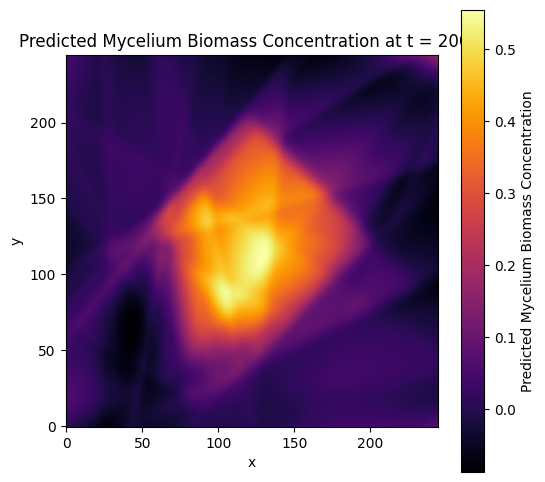

In [13]:
# Step 2: Create a grid for prediction
grid_size_x = 245  # Adjust based on the grid size in your data
grid_size_y = 245

x = np.arange(grid_size_x)
y = np.arange(grid_size_y)
X, Y = np.meshgrid(x, y)

# Select the timestep for which you want the prediction
timestep = 200.0  # For example, t = 200

# Flatten the grid to use it as input to the model
x_grid = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
y_grid = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
t_grid = torch.tensor(np.full(X.flatten().shape, timestep), dtype=torch.float32).unsqueeze(1).to(device)

# Step 3: Predict the mycelium concentration using the PINN
with torch.no_grad():
    M_pred = model(x_grid, y_grid, t_grid).cpu().detach().numpy()

# Reshape the predictions back into the grid form
M_pred_grid = M_pred.reshape(grid_size_x, grid_size_y)

# Step 4: Plot the predicted mycelium concentration as a heatmap
plt.figure(figsize=(6, 6))
plt.imshow(M_pred_grid, cmap='inferno', origin='lower')
plt.colorbar(label='Predicted Mycelium Biomass Concentration')
plt.title(f'Predicted Mycelium Biomass Concentration at t = {timestep}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()